In [1]:
import os
import time
from typing import List, Optional, Tuple
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# Notebook Config

In [2]:
# Color mapping (from class_dict.csv)
COLOR_MAP = {
    (0, 255, 255): 0,  # urban_land
    (255, 255, 0): 1,  # agriculture_land
    (255, 0, 255): 2,  # rangeland
    (0, 255, 0): 3,  # forest_land
    (0, 0, 255): 4,  # water
    (255, 255, 255): 5,  # barren_land
    (0, 0, 0): 6,  # unknown
}
# SETTINGS - change these
LR = 1e-3
EPOCHS = 1
ROOT = "data"  # path where metadata.csv and train/valid/test folders live
METADATA = "metadata.csv"
NUM_CLASSES = 7
IGNORE_CLASS = 6  # class id for 'unknown' from your class_dict (mark as ignore)
IGNORE_INDEX = 255  # sentinel for unlabeled pixels (PartialCE)
BATCH_SIZE = 4
NUM_WORKERS = 0
IMAGE_SIZE = (512, 512)
POINTS_RATIO_PER_CLASS = 0.1  # how many points/class to sample during training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)
PRE_COMPUTED_WEIGHTS_CLASSES = torch.tensor(
    [0.0353, 0.0066, 0.0456, 0.0327, 0.1170, 0.0441, 0.0000], dtype=torch.float32,device=DEVICE
)

# Dataset class — simple, works from lists of paths

In [3]:
class DeepGlobeDataset(Dataset):
    """
    Dataset that returns (image_tensor, mask_tensor) where:
      - image_tensor: (3, H, W) float tensor (0..1 or normalized if transform included)
      - mask_tensor: (H, W) long tensor with class indices [0..6]
    """

    def __init__(
        self,
        image_paths: List[str],
        mask_paths: List[str],
        transform: Optional[callable] = None,
        target_transform: Optional[callable] = None,
    ):
        assert len(image_paths) == len(mask_paths)
        self.image_paths = list(image_paths)
        self.mask_paths = list(mask_paths)
        self.transform = transform
        self.target_transform = target_transform

    def _rgb_to_class(self, mask_img: Image.Image) -> torch.Tensor:
        """
        Convert a PIL RGB mask to a single-channel long tensor of class indices.
        """
        mask_np = np.array(mask_img)  # (H, W, 3)
        label_mask = np.zeros(mask_np.shape[:2], dtype=np.int64)
        for rgb, idx in COLOR_MAP.items():
            rgb_arr = np.array(rgb, dtype=np.uint8).reshape(1, 1, 3)
            matches = np.all(mask_np == rgb_arr, axis=-1)
            label_mask[matches] = int(idx)
        return torch.from_numpy(label_mask).long()  # (H, W)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_p = self.image_paths[idx]
        mk_p = self.mask_paths[idx]

        img = Image.open(img_p).convert("RGB")
        mk = Image.open(mk_p).convert("RGB")

        # image transform (e.g., Resize, ToTensor, Normalize)
        if self.transform:
            img = self.transform(img)
        else:
            img = T.ToTensor()(img)

        # convert color-coded mask -> class indices
        mask_idx = self._rgb_to_class(mk)

        if self.target_transform:
            mask_idx = self.target_transform(mask_idx)

        return img, mask_idx

In [4]:
def mask_transform_fn(mask_tensor_or_pil, image_size=(512, 512)):
    """
    Resize mask (nearest neighbor) and return (H, W) long tensor.
    Accepts either Pillow.Image or torch.Tensor (single-channel or int mask).
    """
    if isinstance(mask_tensor_or_pil, torch.Tensor):
        arr = mask_tensor_or_pil.cpu().numpy().astype(np.uint8)
        pil = Image.fromarray(arr)
    else:
        pil = mask_tensor_or_pil
    resized = pil.resize(image_size, resample=Image.NEAREST)
    return torch.from_numpy(np.array(resized)).long()


# ---------------------------
# Helper to build train/val datasets from metadata
# ---------------------------
def build_train_val_datasets(
    root: str,
    metadata_file: str = "metadata.csv",
    val_ratio: float = 0.1,
    seed: int = 42,
    image_size: Tuple[int, int] = (512, 512),
    val_split_name: str = "valid",
    require_masks_exist: bool = True,
) -> Tuple[DeepGlobeDataset, DeepGlobeDataset]:
    """
    Read metadata.csv and build (train_ds, val_ds).
    - If `valid` rows with masks exist, use them.
    - Otherwise split 'train' rows into train/val with val_ratio.
    This function creates sensible default transforms (image + mask) using image_size.
    """
    meta_path = os.path.join(root, metadata_file)
    df = pd.read_csv(meta_path)

    # minimal cleaning
    df = df.dropna(subset=["sat_image_path", "mask_path"])
    df["sat_image_path"] = df["sat_image_path"].astype(str)
    df["mask_path"] = df["mask_path"].astype(str)

    # default transforms created here (inside function)
    img_tf = T.Compose(
        [
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    # bind image_size into mask_transform via partial (top-level function used)
    mask_tf = partial(mask_transform_fn, image_size=image_size)

    def _pairs_from_df(subdf):
        imgs = [os.path.join(root, p) for p in subdf["sat_image_path"].tolist()]
        masks = [os.path.join(root, p) for p in subdf["mask_path"].tolist()]
        pairs = [
            (i, m)
            for i, m in zip(imgs, masks)
            if (not require_masks_exist) or (os.path.exists(i) and os.path.exists(m))
        ]
        return pairs

    # attempt to use provided valid split if available
    valid_df = df[df["split"] == val_split_name]
    valid_pairs = _pairs_from_df(valid_df)
    if len(valid_pairs) > 0:
        train_pairs = _pairs_from_df(df[df["split"] == "train"])
        print(
            f"[INFO] Using provided valid split: {len(train_pairs)} train / {len(valid_pairs)} valid"
        )
    else:
        # fallback: split train into train+val
        train_df = df[df["split"] == "train"].reset_index(drop=True)
        pairs = _pairs_from_df(train_df)
        if len(pairs) == 0:
            raise ValueError(
                "No train pairs found on disk. Check metadata / file locations."
            )
        rng = np.random.RandomState(seed)
        perm = rng.permutation(len(pairs))
        n_val = max(1, int(len(pairs) * val_ratio))
        val_idx = perm[:n_val]
        train_idx = perm[n_val:]
        train_pairs = [pairs[i] for i in train_idx]
        valid_pairs = [pairs[i] for i in val_idx]
        print(
            f"[INFO] No valid split provided -> split train into {len(train_pairs)} train / {len(valid_pairs)} val (val_ratio={val_ratio})"
        )

    # unzip
    train_imgs, train_masks = zip(*train_pairs)
    val_imgs, val_masks = zip(*valid_pairs)

    # build datasets with the transforms created inside the function
    train_ds = DeepGlobeDataset(
        list(train_imgs), list(train_masks), transform=img_tf, target_transform=mask_tf
    )
    val_ds = DeepGlobeDataset(
        list(val_imgs), list(val_masks), transform=img_tf, target_transform=mask_tf
    )

    return train_ds, val_ds

In [5]:
def visualize_partial_labels(image, full_mask, partial_mask, class_colors=None):
    """
    Shows the original image, full mask, and partial (sampled) mask.
    """
    # Detach tensors
    image = image.detach().cpu()
    full_mask = full_mask.detach().cpu().numpy()
    partial_mask = partial_mask.detach().cpu().numpy()

    # Convert image to HWC
    img_vis = image.permute(1, 2, 0).numpy()
    img_vis = np.clip(img_vis, 0, 1)

    # Define class colors if not provided
    if class_colors is None:
        class_colors = {
            0: [0, 255, 255],
            1: [255, 255, 0],
            2: [255, 0, 255],
            3: [0, 255, 0],
            4: [0, 0, 255],
            5: [255, 255, 255],
            6: [0, 0, 0],
            255: [0, 0, 0],  # ignore (unlabeled)
        }

    def mask_to_rgb(mask):
        rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for cls, color in class_colors.items():
            rgb[mask == cls] = color
        return rgb

    mask_rgb = mask_to_rgb(full_mask)
    partial_rgb = mask_to_rgb(partial_mask)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_vis)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_rgb)
    plt.title("Full Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(partial_rgb)
    plt.title("Sampled Partial Labels")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Model Lightweight UNet (baseline)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    def __init__(self, in_ch=3, num_classes=7, base_filters=32):
        super().__init__()
        f = base_filters
        self.enc1 = ConvBlock(in_ch, f)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(f, f * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(f * 2, f * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(f * 4, f * 8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(f * 8, f * 16)

        self.up4 = nn.ConvTranspose2d(f * 16, f * 8, 2, stride=2)
        self.dec4 = ConvBlock(f * 16, f * 8)
        self.up3 = nn.ConvTranspose2d(f * 8, f * 4, 2, stride=2)
        self.dec3 = ConvBlock(f * 8, f * 4)
        self.up2 = nn.ConvTranspose2d(f * 4, f * 2, 2, stride=2)
        self.dec2 = ConvBlock(f * 4, f * 2)
        self.up1 = nn.ConvTranspose2d(f * 2, f, 2, stride=2)
        self.dec1 = ConvBlock(f * 2, f)

        self.head = nn.Conv2d(f, num_classes, kernel_size=1)

    def forward(self, x):
        # encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.head(d1)
        return out

# Partial Cross Entropy Loss (masked)

In [7]:
class PartialCrossEntropyLoss(nn.Module):
    """
    Partial Cross Entropy Loss for segmentation with sparse labels.
    Supports optional class weighting computed from dataset pixel frequencies.

    Args:
        dataset (Dataset): Dataset used to compute class weights (if weight=None).
        ignore_index (int): Label to ignore in loss computation.
        weight (torch.Tensor | list | np.ndarray | None): Precomputed class weights (shape: [num_classes]).
        reduction (str): One of {'none', 'mean', 'sum'}.
        label_smoothing (float): Optional label smoothing.
    """

    def __init__(
        self,
        dataset=None,
        ignore_index: int = 255,
        weight: torch.Tensor = None,
        reduction: str = "mean",
        label_smoothing: float = 0.0,
        num_classes: int = 7,
        ignore_label: int = 6,
    ):
        super().__init__()
        assert reduction in ("none", "mean", "sum")
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.label_smoothing = float(label_smoothing)

        if weight is not None:
            # rename to avoid shadowing builtins
            w = (
                weight.clone()
                if isinstance(weight, torch.Tensor)
                else torch.tensor(weight, dtype=torch.float32)
            )
            self.register_buffer("_weight", w)
            print(
                f"[INFO] Using precomputed class weights: {torch.round(w, decimals=3).tolist()}"
            )

        elif dataset is not None:
            print(
                "[INFO] No weights provided — computing class weights from dataset ..."
            )
            w = self.compute_class_weights_from_dataset(
                dataset=dataset,
                num_classes=num_classes,
                ignore_label=ignore_label,
                normalize=True,
                mode="inverse_freq",
            )
        else:
            self.register_buffer("_weight", None)
            print(
                "[WARN] No class weights or dataset provided — using uniform weighting."
            )

    # --------------------------
    @property
    def weight(self):
        """Access the registered weight tensor."""
        return self._weight

    # -----------------------------------
    # Compute class weights from dataset
    # -----------------------------------
    @torch.no_grad()
    def compute_class_weights_from_dataset(
        self,
        dataset,
        num_classes: int,
        ignore_label: int = None,
        normalize: bool = True,
        mode: str = "inverse_freq",
    ):
        """
        Compute and set class weights automatically from dataset pixel counts.

        Args:
            dataset: A dataset yielding (image, mask) where mask is (H, W) tensor.
            num_classes (int): Total number of semantic classes.
            ignore_label (int, optional): Class to ignore (weight = 0).
            normalize (bool): Whether to normalize weights so mean = 1.
            mode (str): 'inverse_freq' or 'log_inv_freq'
        """
        counts = np.zeros(num_classes, dtype=np.float64)

        for i in range(len(dataset)):
            _, mask = dataset[i]
            mask = mask.cpu().numpy().ravel()
            for c in range(num_classes):
                counts[c] += (mask == c).sum()

        # avoid divide by zero
        counts = np.maximum(counts, 1e-6)

        if mode == "inverse_freq":
            weights = 1.0 / counts
        elif mode == "log_inv_freq":
            weights = 1.0 / np.log(1.02 + counts)
        else:
            raise ValueError("mode must be 'inverse_freq' or 'log_inv_freq'")

        if normalize:
            weights = weights / weights.mean()

        if ignore_label is not None and ignore_label < len(weights):
            weights[ignore_label] = 0.0

        print("[INFO] Computed class weights:", np.round(weights, 3).tolist())
        return torch.tensor(weights, dtype=torch.float32)

    # --------------------------
    # Forward (standard partial CE)
    # --------------------------
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if inputs.dim() != 4:
            raise ValueError("inputs must be (B, C, H, W)")
        if targets.dim() != 3:
            raise ValueError("targets must be (B, H, W)")

        B, C, H, W = inputs.shape
        logits = inputs.permute(0, 2, 3, 1).reshape(-1, C)
        flat_targets = targets.reshape(-1)

        mask = flat_targets != self.ignore_index
        if mask.sum() == 0:
            zero = torch.tensor(0.0, dtype=inputs.dtype, device=inputs.device)
            if self.reduction == "none":
                return zero.new_zeros((0,))
            return zero

        logits_masked = logits[mask]
        targets_masked = flat_targets[mask]

        loss = F.cross_entropy(
            logits_masked,
            targets_masked,
            weight=self.weight,
            reduction="none",
            label_smoothing=self.label_smoothing,
        )

        if self.reduction == "none":
            return loss
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

# Helper Functions

In [8]:
# -------------------------
# Point-sampler (simulate partial labels)
# -------------------------
def sample_point_labels(
    full_mask: torch.Tensor,
    keep_ratio: float = 0.01,  # e.g. keep 1% of labeled pixels
    ignore_index: int = 255,
    classes: list = None,
):
    """
    Randomly sample a subset of labeled pixels from a full segmentation mask,
    keeping a given percentage of pixels per class.

    This simulates *partial supervision* by retaining only a fraction of pixels
    from each class, while marking the rest as unlabeled (ignore_index).

    Args:
        full_mask (torch.Tensor):
            Ground-truth segmentation mask.
            Expected shapes: (H, W), (1, H, W), or (H, W, 1).
            Each pixel contains a class ID.
        keep_ratio (float):
            Fraction of pixels to retain per class (e.g., 0.01 = 1% of pixels for each class).
            Sampling is done independently per class to preserve class balance.
        ignore_index (int):
            Label value used to mark unlabeled pixels.
            These are ignored during loss computation (e.g., in PartialCrossEntropyLoss).
        classes (list, optional):
            Specific class IDs to sample from. If None, inferred from the mask.

    Returns:
        torch.Tensor:
            A tensor of shape (H, W) where:
              - Sampled pixels retain their original class IDs
              - All other pixels are set to `ignore_index`

    Notes:
        - Sampling is performed *per class* (each class keeps the same ratio of its own pixels).
        - Ensures at least one pixel is kept per class, even for rare classes.
        - Useful for simulating point-level or sparse segmentation supervision.

    Example:
        >>> mask = torch.randint(0, 5, (512, 512))
        >>> sampled = sample_point_labels(mask, keep_ratio=0.02)
        >>> (sampled != 255).float().mean()
        tensor(0.0201)  # ~2% of pixels retained per class
    """
    # --- Normalize shape ---
    if full_mask.ndim == 4:  # (B, 1, H, W)
        full_mask = full_mask.squeeze(0)
    if full_mask.ndim == 3:
        if full_mask.shape[0] == 1:
            full_mask = full_mask.squeeze(0)
        elif full_mask.shape[-1] == 1:
            full_mask = full_mask.squeeze(-1)
        else:
            # If RGB mask (e.g., color-coded), take first channel (should already be converted before)
            full_mask = full_mask[0]
    elif full_mask.ndim > 4 or full_mask.ndim < 2:
        raise ValueError(f"Unexpected mask shape: {full_mask.shape}")

    H, W = full_mask.shape[-2], full_mask.shape[-1]
    full_mask = full_mask.long()

    # --- Initialize mask with ignore_index ---
    point_mask = torch.full(
        (H, W), ignore_index, dtype=torch.long, device=full_mask.device
    )

    # --- Determine classes present ---
    unique = torch.unique(full_mask)
    if classes is not None:
        unique = [c for c in unique if c in classes]

    # --- Sample by ratio ---
    for c in unique:
        if c == ignore_index:
            continue
        ys, xs = torch.where(full_mask == c)
        if len(ys) == 0:
            continue
        num_keep = max(1, int(len(ys) * keep_ratio))  # at least 1 pixel
        idx = torch.randperm(len(ys))[:num_keep]
        point_mask[ys[idx], xs[idx]] = c

    return point_mask


# -------------------------
# mIoU metric for validation
# -------------------------
def compute_confusion_matrix(
    preds: torch.Tensor,
    targets: torch.Tensor,
    num_classes: int,
    ignore_index: int = 255,
):
    """
    preds: (N, H, W) long
    targets: (N, H, W) long
    Returns: confusion matrix shape (num_classes, num_classes)
    """
    mask = targets != ignore_index
    preds = preds[mask]
    targets = targets[mask]
    if targets.numel() == 0:
        return torch.zeros((num_classes, num_classes), dtype=torch.long)
    k = (targets >= 0) & (targets < num_classes)
    preds = preds[k]
    targets = targets[k]
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)
    idx = num_classes * targets + preds
    vals, counts = torch.unique(idx, return_counts=True)
    for v, c in zip(vals.tolist(), counts.tolist()):
        t = v // num_classes
        p = v % num_classes
        conf[t, p] += c
    return conf


def compute_miou_from_conf(conf_matrix: torch.Tensor, ignore_classes: List[int] = None):
    if ignore_classes is None:
        ignore_classes = []
    num_classes = conf_matrix.shape[0]
    ious = []
    for cls in range(num_classes):
        if cls in ignore_classes:
            ious.append(float("nan"))
            continue
        tp = conf_matrix[cls, cls].item()
        fn = conf_matrix[cls, :].sum().item() - tp
        fp = conf_matrix[:, cls].sum().item() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else float("nan")
        ious.append(iou)
    # mean over valid classes
    valid = [
        x
        for i, x in enumerate(ious)
        if i not in (ignore_classes or []) and not np.isnan(x)
    ]
    miou = float(np.nanmean(valid)) if len(valid) > 0 else 0.0
    return miou, ious


# -------------------------
# Training / Validation loops
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, keep_ratio_per_class):
    model.train()
    running_loss = 0.0
    n_batches = 0
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        # Create point supervision masks
        batch_point_masks = []
        for b in range(images.size(0)):
            pm = sample_point_labels(
                masks[b],
                keep_ratio=keep_ratio_per_class,
                ignore_index=criterion.ignore_index,
            )
            batch_point_masks.append(pm)
        point_masks = torch.stack(batch_point_masks, dim=0)  # (B, H, W)

        optimizer.zero_grad()
        logits = model(images)  # (B, C, H, W)
        loss = criterion(logits, point_masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1
    return running_loss / max(1, n_batches)


def validate(
    model, loader, device, num_classes, ignore_index=255, ignore_eval_classes=None
):
    model.eval()
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)  # (B, H, W)
            conf_batch = compute_confusion_matrix(
                preds.cpu(), masks.cpu(), num_classes, ignore_index=ignore_index
            )
            conf += conf_batch
    miou, ious = compute_miou_from_conf(conf, ignore_classes=ignore_eval_classes)
    return miou, ious

In [9]:
def run_training():
    train_ds, val_ds = build_train_val_datasets(
        root=ROOT,
        metadata_file=METADATA,
        val_ratio=0.1,
        seed=42,
        image_size=IMAGE_SIZE,
    )

    print("Train samples:", len(train_ds))
    print("Val samples:", len(val_ds))

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    # Model, loss, optimizer
    criterion = PartialCrossEntropyLoss(
        weight=PRE_COMPUTED_WEIGHTS_CLASSES,
        ignore_index=255,
        reduction="mean",
    )
    model = UNet(in_ch=3, num_classes=NUM_CLASSES, base_filters=32).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    best_miou = -1.0
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            DEVICE,
            keep_ratio_per_class=POINTS_RATIO_PER_CLASS,
        )
        val_miou, val_ious = validate(
            model,
            val_loader,
            DEVICE,
            NUM_CLASSES,
            ignore_index=IGNORE_INDEX,
            ignore_eval_classes=[IGNORE_CLASS],
        )
        scheduler.step()

        elapsed = time.time() - t0
        print(
            f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f} — val_mIoU: {val_miou:.4f} — time: {elapsed:.1f}s"
        )
        print(
            " per-class IoU:",
            ["{:.3f}".format(x) if not np.isnan(x) else "nan" for x in val_ious],
        )

        # Save best
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "miou": val_miou,
                },
                os.path.join(SAVE_DIR, f"unet_partial_best.pth"),
            )
        break
    print("Training complete. Best mIoU:", best_miou)

## Inspect dataset

[INFO] No valid split provided -> split train into 723 train / 80 val (val_ratio=0.1)
Train samples: 723, Val samples: 80
Image shape: torch.Size([3, 512, 512]), Mask shape: torch.Size([512, 512]), Unique labels: tensor([0, 1, 2, 4, 5])
Partial mask unique labels: tensor([  0,   1,   2,   4,   5, 255])


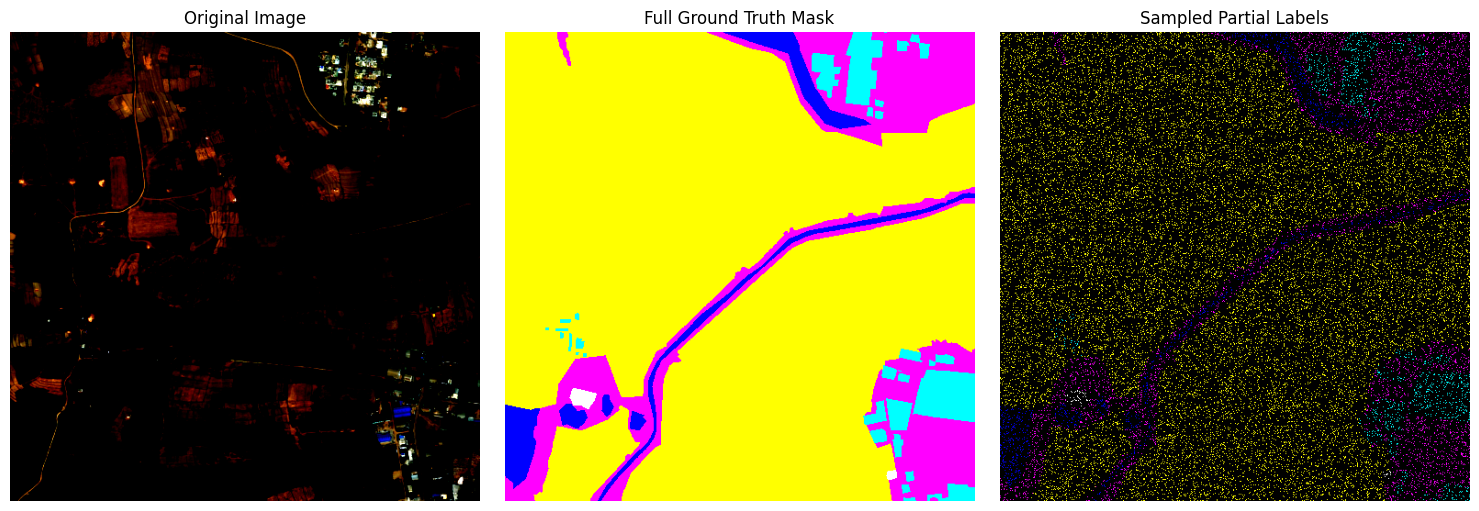

In [10]:
train_ds, val_ds = build_train_val_datasets(
    root=ROOT,
    metadata_file=METADATA,
    val_ratio=0.1,
    seed=42,
    image_size=(512, 512),
)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")
img, mask = train_ds[1]
print(
    f"Image shape: {img.shape}, Mask shape: {mask.shape}, Unique labels: {torch.unique(mask)}"
)

# Sample sparse partial labels (keep 5% pixels per class)
partial_mask = sample_point_labels(
    mask, keep_ratio=POINTS_RATIO_PER_CLASS, ignore_index=255
)
print("Partial mask unique labels:", partial_mask.unique())
visualize_partial_labels(img, mask, partial_mask)

In [ ]:
if __name__ == "__main__":
    run_training()

[INFO] No valid split provided -> split train into 723 train / 80 val (val_ratio=0.1)
Train samples: 723
Val samples: 80
[INFO] Using precomputed class weights: [0.03500000014901161, 0.007000000216066837, 0.04600000008940697, 0.032999999821186066, 0.11699999868869781, 0.04399999976158142, 0.0]
